<a href="https://colab.research.google.com/github/zeeraknaveed/QML/blob/main/gas_prices_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Data Loading

In [3]:
# === Load training/validation data
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/cleaned_data.csv')  # Load training dataset from CSV
df['date'] = pd.to_datetime(df['date'])  # Convert 'date' column to datetime format
df.set_index('date', inplace=True)  # Set 'date' column as index for time series operations

# === Load external test data
df_test = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/cleaned_data_test.csv')  # Load test dataset from CSV
df_test['date'] = pd.to_datetime(df_test['date'])  # Convert 'date' column to datetime format
df_test.set_index('date', inplace=True)  # Set 'date' column as index

# Clean Timeseries Data

In [ ]:
import pandas as pd

def clean_timeseries_data(input_csv_path, output_csv_path=None, date_column='date', drop_thresh=0.7):
    """
    Cleans a time series CSV by handling missing values and formatting the date column.

    Parameters:
    - input_csv_path: Path to the raw CSV file
    - output_csv_path: Optional path to save cleaned CSV
    - date_column: Name of the column containing dates
    - drop_thresh: Threshold for dropping columns (e.g., 0.7 = drop columns with >70% NaNs)

    Returns:
    - Cleaned pandas DataFrame
    """

    # Load the CSV file
    df = pd.read_csv(input_csv_path, header=0)

    # Convert the date column to datetime format
    df[date_column] = pd.to_datetime(df[date_column], format='%Y-%m-%d')

    # Interpolate missing electricity prices (only if the column exists)
    if 'Electricity_Price_USA' in df.columns:
        df['Electricity_Price_USA'] = df['Electricity_Price_USA'].interpolate(
            method='linear',
            limit_direction='forward'
        )

    # Drop columns that have more than 'drop_thresh' percentage of missing values
    df = df.loc[:, df.isnull().mean() < drop_thresh]

    # Fill remaining missing values using backward fill
    df.bfill(inplace=True)

    # Drop any rows that still contain NaNs
    df.dropna(inplace=True)

    # Save cleaned data to output file if specified
    if output_csv_path:
        df.to_csv(output_csv_path, index=False)
        print(f"✅ Cleaned data saved to: {output_csv_path}")

    return df

In [ ]:
clean_df = clean_timeseries_data(
    input_csv_path='data_test.csv',
    output_csv_path='cleaned_data_test.csv'
)

# Calculate Correlations

In [9]:
fixed_var = 'Natural_Gas_US_Henry_Hub_Gas'
correlations = df.corr()[fixed_var].sort_values(ascending=False)
print(correlations)

Natural_Gas_US_Henry_Hub_Gas                 1.000000
import_price_index_natural_gas               0.912394
BCOMCL_INDX                                  0.872275
Natural_Gas_Rotary_Rig_Count_USA             0.806442
Kilian_Global_Economy_Index_WORLD            0.715981
                                               ...   
PPI_Manufacturing_Sector_USA                -0.598277
BCOMGC_INDX                                 -0.642820
CPI_Index_Seasonally_Adjusted_USA           -0.686058
Total_Natural_Gas_Marketed_Production_USA   -0.692132
CLI_Comp_Construction_Production_CHN        -0.728561
Name: Natural_Gas_US_Henry_Hub_Gas, Length: 111, dtype: float64


In [10]:
corr_series = df.corr()['Natural_Gas_US_Henry_Hub_Gas']
filtered_corr = corr_series[(corr_series >= 0.2) | (corr_series <= -0.2)].sort_values(ascending=False)
print(filtered_corr)

Natural_Gas_US_Henry_Hub_Gas                 1.000000
import_price_index_natural_gas               0.912394
BCOMCL_INDX                                  0.872275
Natural_Gas_Rotary_Rig_Count_USA             0.806442
Kilian_Global_Economy_Index_WORLD            0.715981
                                               ...   
PPI_Manufacturing_Sector_USA                -0.598277
BCOMGC_INDX                                 -0.642820
CPI_Index_Seasonally_Adjusted_USA           -0.686058
Total_Natural_Gas_Marketed_Production_USA   -0.692132
CLI_Comp_Construction_Production_CHN        -0.728561
Name: Natural_Gas_US_Henry_Hub_Gas, Length: 69, dtype: float64


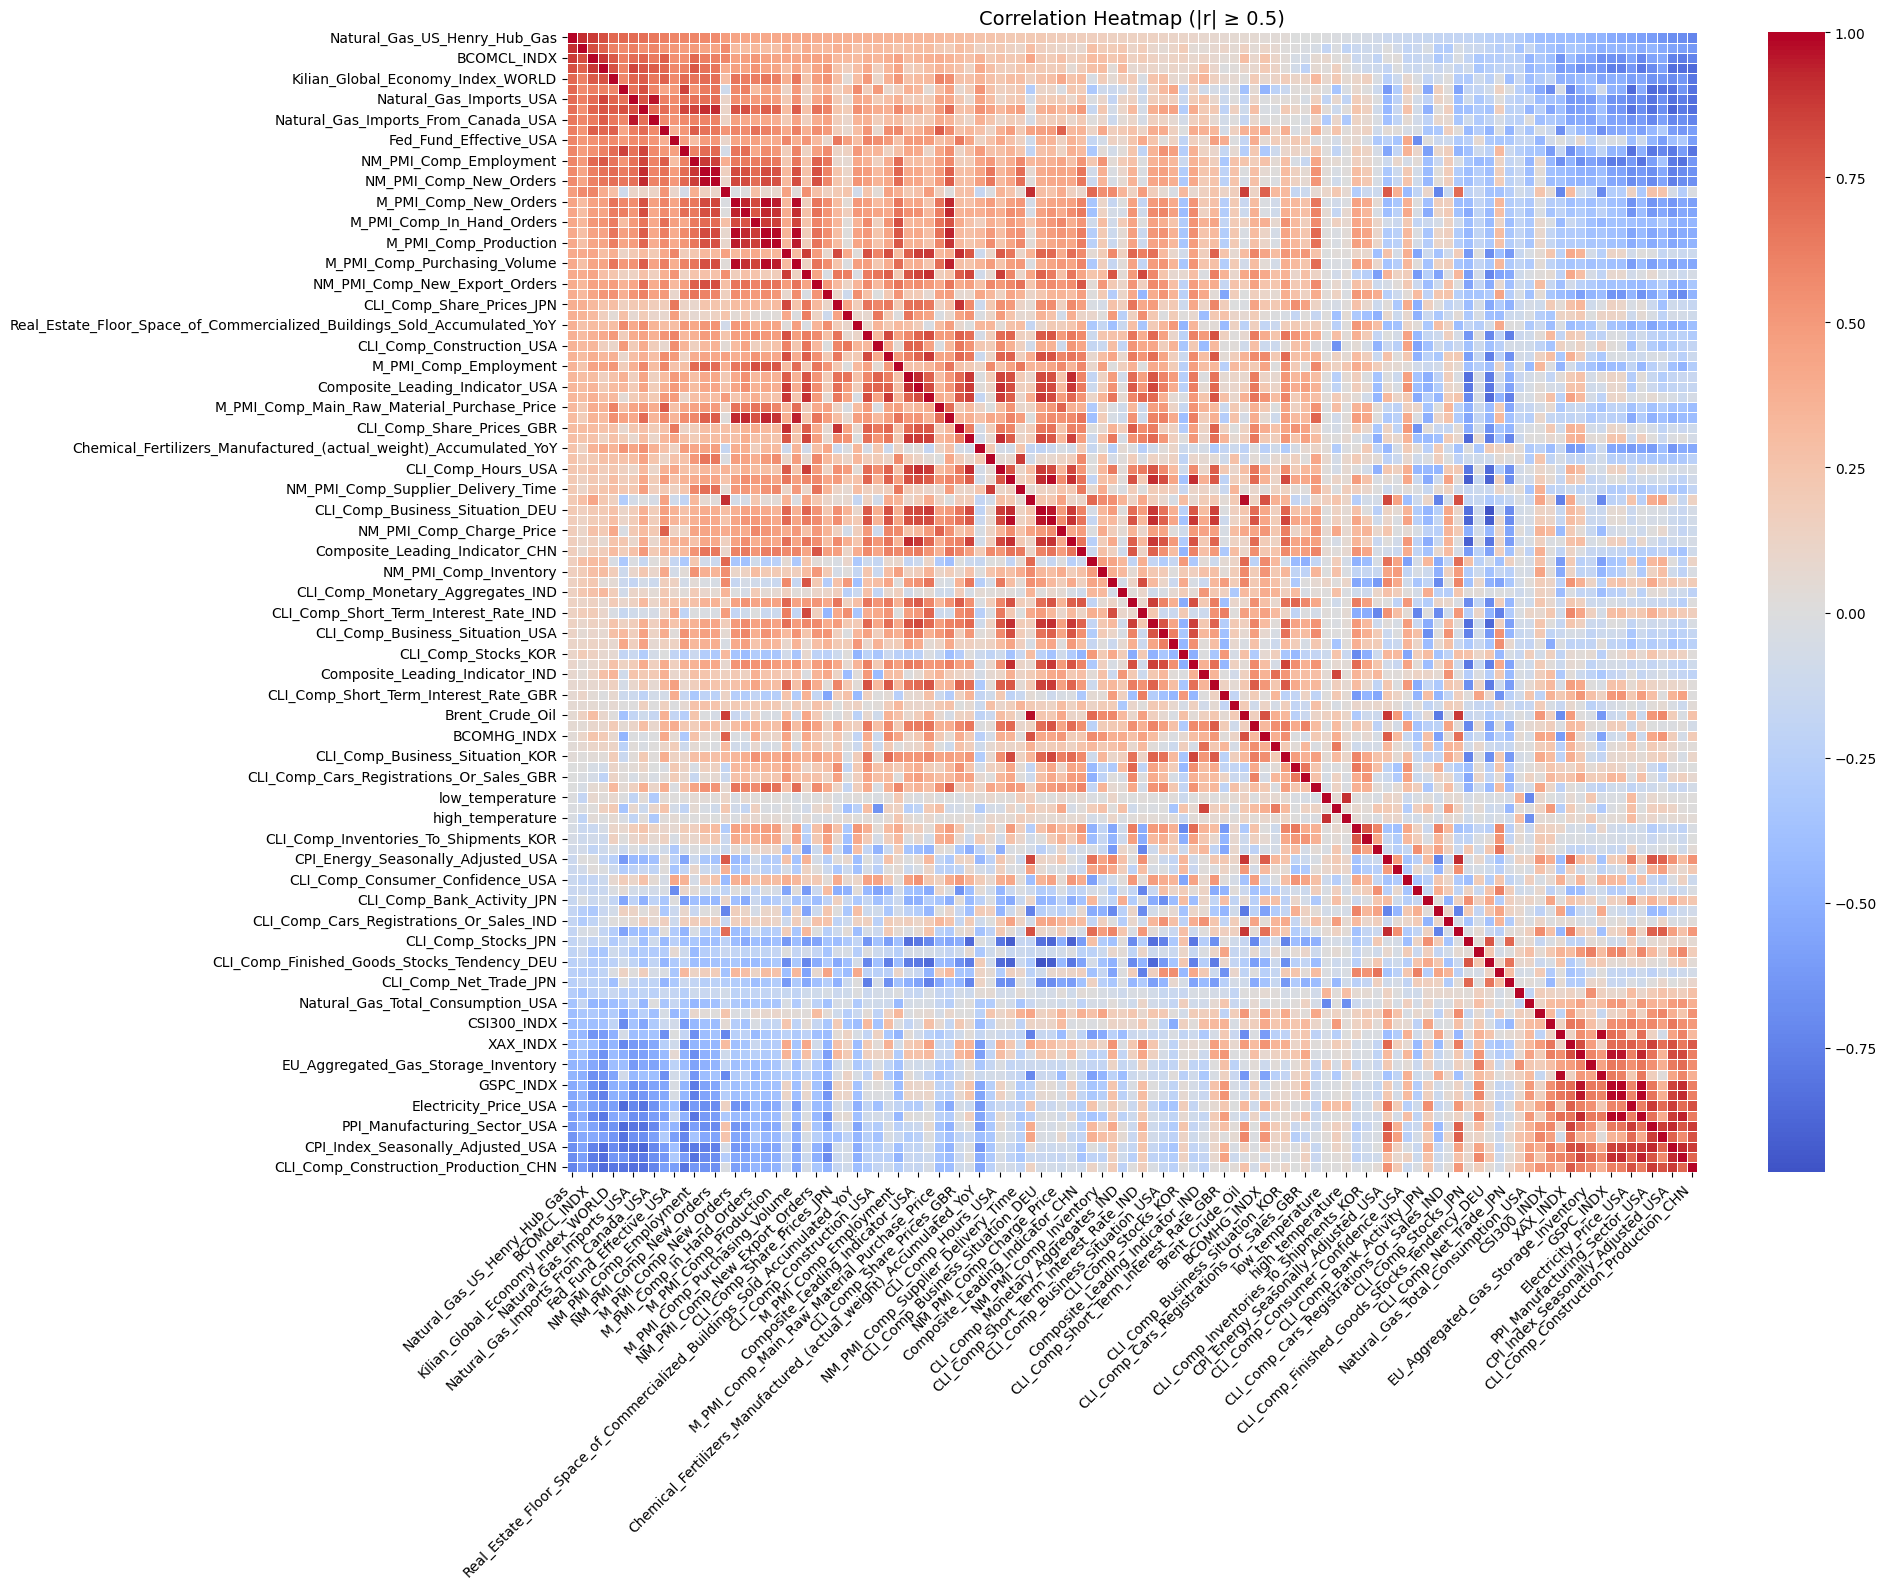

In [11]:
import seaborn as sns

# Create a DataFrame with only the top-correlated variables
top_vars = correlations.index.tolist()
df_top = df[top_vars].corr()  # Assuming `df` is your original data

# Plot
plt.figure(figsize=(20, 16))
sns.heatmap(df_top, annot=False, cmap="coolwarm", center=0, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (|r| ≥ 0.5)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# PCA Analysis

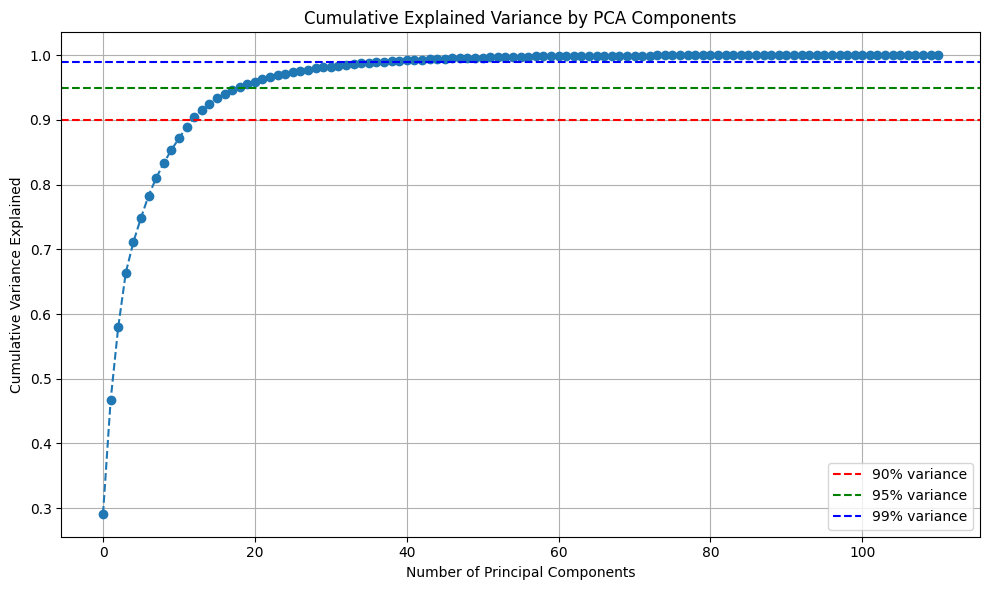

Components for 90% variance: 13
Components for 95% variance: 19
Components for 99% variance: 39


In [12]:
# === 1. Select only numeric columns (PCA requires numeric input)
X = df.select_dtypes(include=[np.number])

# === 2. Standardize the features (PCA is sensitive to scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 3. Fit PCA on the scaled data
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# === 4. Calculate how much variance each principal component explains
explained_var_ratio = pca.explained_variance_ratio_

# === 5. Calculate cumulative variance explained (to decide how many components to keep)
cumulative_var = np.cumsum(explained_var_ratio)

# === 6. Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_var, marker='o', linestyle='--')  # Cumulative curve
plt.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
plt.axhline(y=0.99, color='b', linestyle='--', label='99% variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 7. Function to find how many components are needed to reach a threshold
def components_needed(threshold):
    return np.argmax(cumulative_var >= threshold) + 1  # Add 1 since index starts at 0

# === 8. Print number of components required for different thresholds
n_90 = components_needed(0.90)
n_95 = components_needed(0.95)
n_99 = components_needed(0.99)

print(f"Components for 90% variance: {n_90}")
print(f"Components for 95% variance: {n_95}")
print(f"Components for 99% variance: {n_99}")

# === 9. Reduce original data to only components that explain 95% of variance
pca_95 = PCA(n_components=n_95)
X_reduced = pca_95.fit_transform(X_scaled)

# === 10. Convert reduced data to DataFrame with named columns
reduced_df = pd.DataFrame(X_reduced, columns=[f'PC{i+1}' for i in range(n_95)])

# === 11. (Optional) Save the reduced data to a CSV file
# reduced_df.to_csv("reduced_pca_data.csv", index=False)

# Extended Lag History Setup (To be used later)

In [13]:
# === STEP 1: Extract 2019 rows from the training set to use as lag history
df_2019 = df[df.index.year == 2019]

# === STEP 2: Combine 2019 training history with the test data
# This ensures we have enough data before the first test date to calculate lag_1 to lag_12
combined = pd.concat([df_2019, df_test])

# === STEP 3: Create lag features (lag_1 to lag_12) using the full combined data
# Lag features are calculated on the entire series so test dates get valid lag values
target_col = 'Natural_Gas_US_Henry_Hub_Gas'
for lag in range(1, 13):
    combined[f'lag_{lag}'] = combined[target_col].shift(lag)

# === STEP 4: After creating lags, extract only the test period from the combined data
# This gives the test set rows, now enriched with lag features based on 2019 history
df_test_with_lags = combined.loc[df_test.index]

# === STEP 5: (Optional) Preview the test data with lags to ensure everything looks correct
# print(df_test_with_lags.head())

<ipython-input-13-627a372ae8b8>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined[f'lag_{lag}'] = combined[target_col].shift(lag)
<ipython-input-13-627a372ae8b8>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined[f'lag_{lag}'] = combined[target_col].shift(lag)
<ipython-input-13-627a372ae8b8>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

# Training ARIMA Model

In [14]:
# === Select the target variable (gas prices) from both train and test datasets
y = df['Natural_Gas_US_Henry_Hub_Gas']
y_test = df_test['Natural_Gas_US_Henry_Hub_Gas']

# === Split the internal data into training and validation sets (90% train, 10% val)
train_size = int(len(y) * 0.9)
train, val = y[:train_size], y[train_size:]

# === Fit ARIMA model on the full internal series (train + validation)
# (p, d, q) = (10, 1, 2) → ARIMA model order
model = ARIMA(y, order=(10,1,2))
model_fit = model.fit()  # Fit the model

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


# Final ARIMA Evaluation Block

ARIMA RMSE on External Test Set: 7.9984


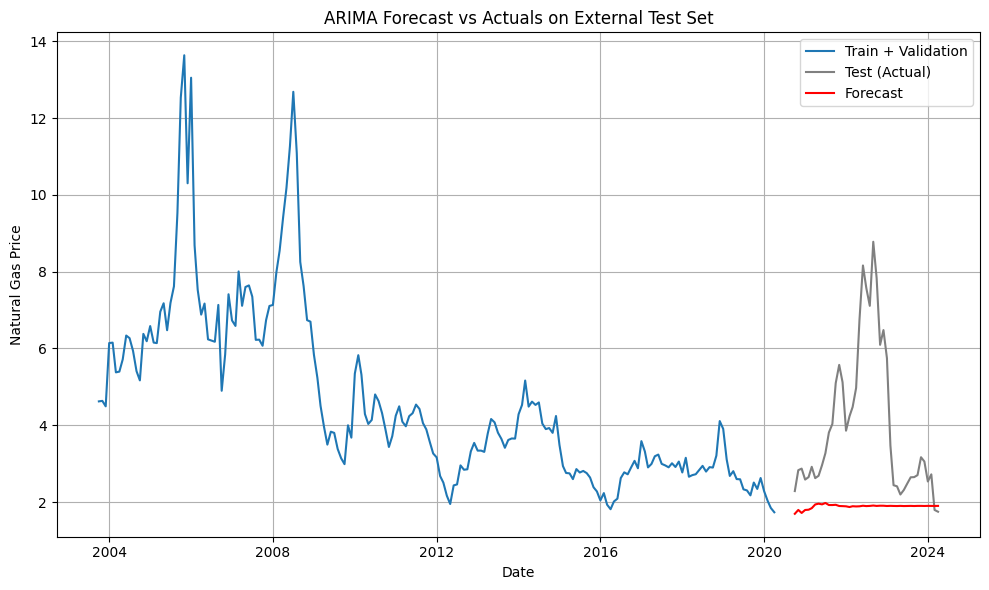

In [15]:
# === Forecast the same number of steps as the test set length
# This generates predictions starting right after the end of the internal data (y)
forecast = model_fit.forecast(steps=len(y_test))

# === Evaluate forecast using RMSE on the external test set
rmse = mean_squared_error(y_test, forecast)
print(f'ARIMA RMSE on External Test Set: {rmse:.4f}')

# === Plot the full series: training, test, and forecast
plt.figure(figsize=(10, 6))

plt.plot(y, label='Train + Validation')             # Internal training + validation
plt.plot(y_test, label='Test (Actual)', color='gray')  # Actual test values
plt.plot(y_test.index, forecast, label='Forecast', color='red')  # Forecasted values

plt.legend()
plt.title('ARIMA Forecast vs Actuals on External Test Set')  # Suggested title
plt.xlabel('Date')
plt.ylabel('Natural Gas Price')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3-Month Ahead ARIMA Forecast

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

            forecast
2024-04-30  1.834722
2024-05-31  1.852913
2024-06-30  1.771937


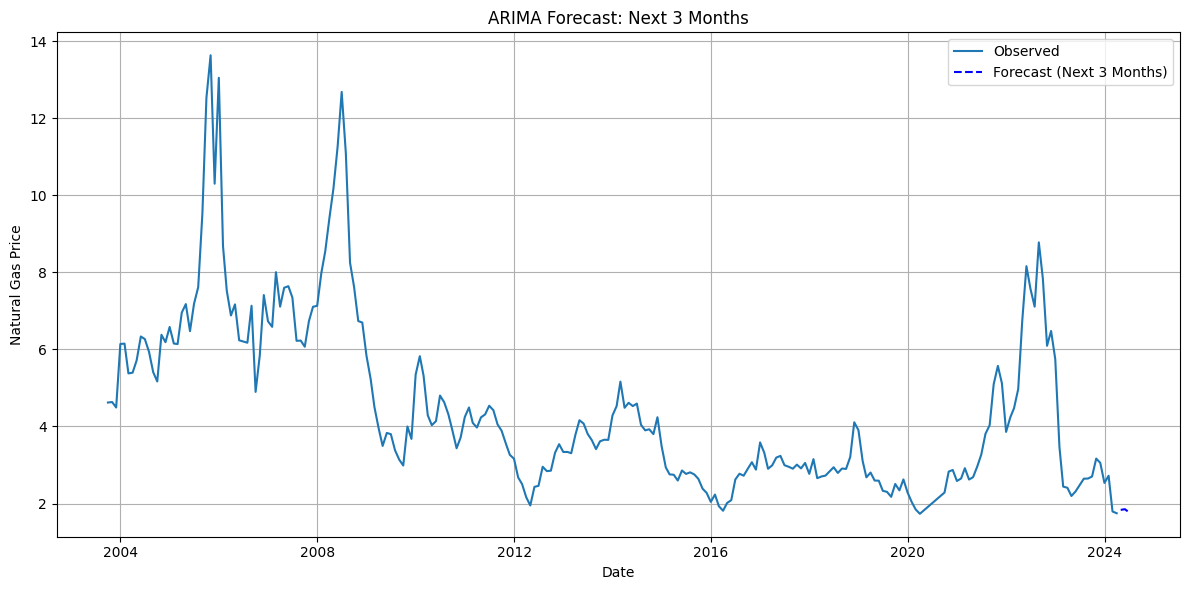

In [16]:
# === Load your full training + test target series
y_full = pd.concat([y, y_test])  # Combine training + test data to forecast beyond known values

# === Fit ARIMA model on the entire known series
model = ARIMA(y_full, order=(10, 1, 2))
model_fit = model.fit()

# === Forecast the next 3 time steps (monthly)
forecast_3mo = model_fit.forecast(steps=3)

# === Generate the corresponding future dates (monthly)
last_known_date = y_full.index[-1]  # Last date in known data
future_dates = pd.date_range(start=last_known_date + pd.offsets.MonthEnd(1), periods=3, freq='M')

# === Create a DataFrame for the 3-month forecast
forecast_df = pd.DataFrame({'forecast': forecast_3mo.values}, index=future_dates)

# === Print the forecasted values
print(forecast_df)

# === Plot the full historical series and the future 3-month forecast
plt.figure(figsize=(12, 6))
plt.plot(y_full.index, y_full, label='Observed')  # Full known data
plt.plot(forecast_df.index, forecast_df['forecast'],
         label='Forecast (Next 3 Months)', color='blue', linestyle='--')  # 3-step future forecast
plt.title('ARIMA Forecast: Next 3 Months')
plt.xlabel('Date')
plt.ylabel('Natural Gas Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# XGBoost Training with Lag Features

In [17]:
# === Select the target variable from the DataFrame
target_col = 'Natural_Gas_US_Henry_Hub_Gas'
df = df[[target_col]]  # Keep only the target column

# === Create lag features (lag_1 to lag_12) to use past values as input features
for lag in range(1, 13):  # Look back 12 months
    df[f'lag_{lag}'] = df[target_col].shift(lag)

# === Drop rows with NaNs caused by lagging (first 12 rows will be NaN in lag columns)
df.dropna(inplace=True)

# === Define input features (X) and target variable (y)
X = df.drop(columns=[target_col])  # Features: lag_1 to lag_12
y = df[target_col]  # Target: natural gas price

# === Split data into train and test sets
split_idx = int(len(df) * 0.9)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# === Train XGBoost regression model on all available data
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X, y)

<ipython-input-17-9dfe15d4b43b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{lag}'] = df[target_col].shift(lag)
<ipython-input-17-9dfe15d4b43b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{lag}'] = df[target_col].shift(lag)
<ipython-input-17-9dfe15d4b43b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# XGBoost Test Forecast & Evaluation

<ipython-input-18-fc268207aace>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f'lag_{lag}'] = df_test[target_col].shift(lag)
<ipython-input-18-fc268207aace>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f'lag_{lag}'] = df_test[target_col].shift(lag)
<ipython-input-18-fc268207aace>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

XGBoost RMSE: 1.0694


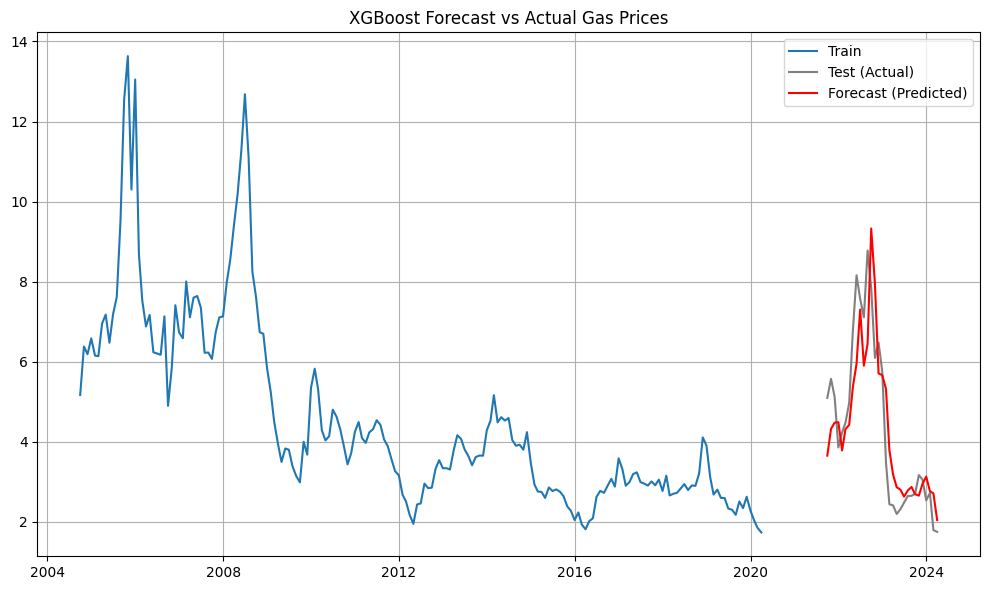

In [18]:
# === Select the target variable from the test set
target_col = 'Natural_Gas_US_Henry_Hub_Gas'
df_test = df_test[[target_col]]  # Keep only the target column

# === Create lag features (lag_1 to lag_12) in the test data
for lag in range(1, 13):
    df_test[f'lag_{lag}'] = df_test[target_col].shift(lag)

# === Drop rows with NaNs caused by lagging (first 12 rows will be NaN in lag columns)
df_test.dropna(inplace=True)

# === Define test features (X_test) and test target (y_test)
X_test = df_test.drop(columns=[target_col])  # Features: lag_1 to lag_12
y_test = df_test[target_col]  # Actual gas prices

# === Use the trained model to predict on test data
y_pred = model.predict(X_test)

# === Evaluate model performance using RMSE
rmse = mean_squared_error(y_test, y_pred)
print(f'XGBoost RMSE: {rmse:.4f}')

# === Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Train')  # Plot training data
plt.plot(y_test.index, y_test, label='Test (Actual)', color='gray')  # Actual test values
plt.plot(y_test.index, y_pred, label='Forecast (Predicted)', color='red')  # Forecasted values
plt.legend()
plt.title('XGBoost Forecast vs Actual Gas Prices')  # Descriptive title
plt.grid(True)
plt.tight_layout()
plt.show()

# Forecast Future Natural Gas Prices (XGBoost, 7 Months Ahead)

📅 Forecasted Future Values:
            forecast
date                
2024-04-30  1.890630
2024-05-31  2.266811
2024-06-30  2.714894
2024-07-31  3.032948
2024-08-31  3.000449
2024-09-30  3.320124
2024-10-31  3.913571


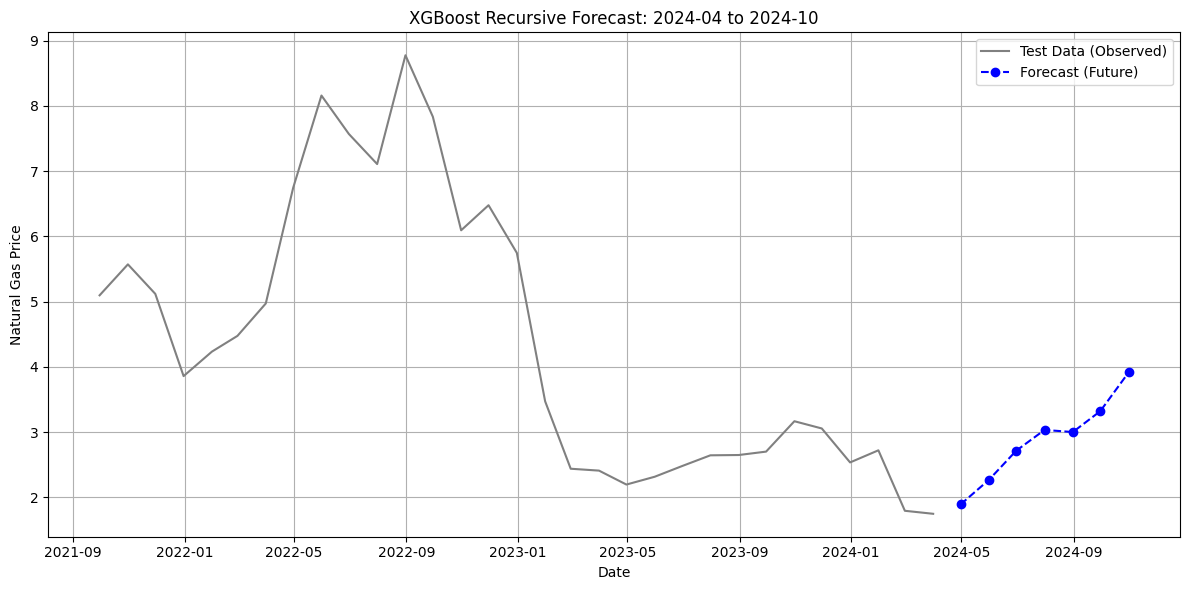

In [19]:
# === Define future dates you want to forecast (monthly steps)
future_dates = ['2024-04-30', '2024-05-31', '2024-06-30',
                '2024-07-31', '2024-08-31', '2024-09-30', '2024-10-31']

# === Initialize list to store future predictions
future_preds = []

# === Create a working copy of the test set to simulate forecasting
latest_known = df_test.copy()  # This will grow as we append predictions

# === Loop through each future date and predict using last 12 values
for forecast_date in future_dates:
    # Step 1: Get the latest 12 known or predicted values (most recent first)
    latest_row = latest_known[target_col].iloc[-12:].values[::-1]  # reverse for lag_1 to lag_12

    # Step 2: Build input dictionary for the model
    input_dict = {f'lag_{i+1}': latest_row[i] for i in range(12)}
    input_df = pd.DataFrame([input_dict])  # Single-row DataFrame for prediction

    # Step 3: Make prediction using the trained XGBoost model
    pred = model.predict(input_df)[0]

    # Step 4: Save forecast result with its date
    future_preds.append((forecast_date, pred))

    # Step 5: Simulate the passage of time by adding this prediction to latest_known
    new_row = pd.DataFrame({target_col: pred}, index=[pd.to_datetime(forecast_date)])
    latest_known = pd.concat([latest_known, new_row])

# === Convert predictions to a DataFrame for visualization
forecast_df = pd.DataFrame(future_preds, columns=['date', 'forecast'])
forecast_df['date'] = pd.to_datetime(forecast_df['date'])
forecast_df.set_index('date', inplace=True)

# === Output forecasted values
print("📅 Forecasted Future Values:")
print(forecast_df)

# === Plot: historical test data + future forecast
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test[target_col], label='Test Data (Observed)', color='gray')
plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast (Future)', color='blue', linestyle='--', marker='o')
plt.title('XGBoost Recursive Forecast: 2024-04 to 2024-10')
plt.xlabel('Date')
plt.ylabel('Natural Gas Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Rolling 3-Month Forecasting Using XGBoost with Lag History

<ipython-input-20-e0f3ca188c47>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined[f'lag_{lag}'] = combined[target_col].shift(lag)
<ipython-input-20-e0f3ca188c47>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined[f'lag_{lag}'] = combined[target_col].shift(lag)
<ipython-input-20-e0f3ca188c47>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 


📊 3-Month Forecasts for All Valid Base Dates:
              pred_1    pred_2    pred_3
date                                    
2020-09-30  2.034117  2.347250  2.500622
2020-10-31  2.020614  2.027884  2.359997
2020-11-30  2.636920  2.020614  2.027884
2020-12-31  2.971267  2.641787  2.016979
2021-01-31  2.554089  2.971267  2.641787


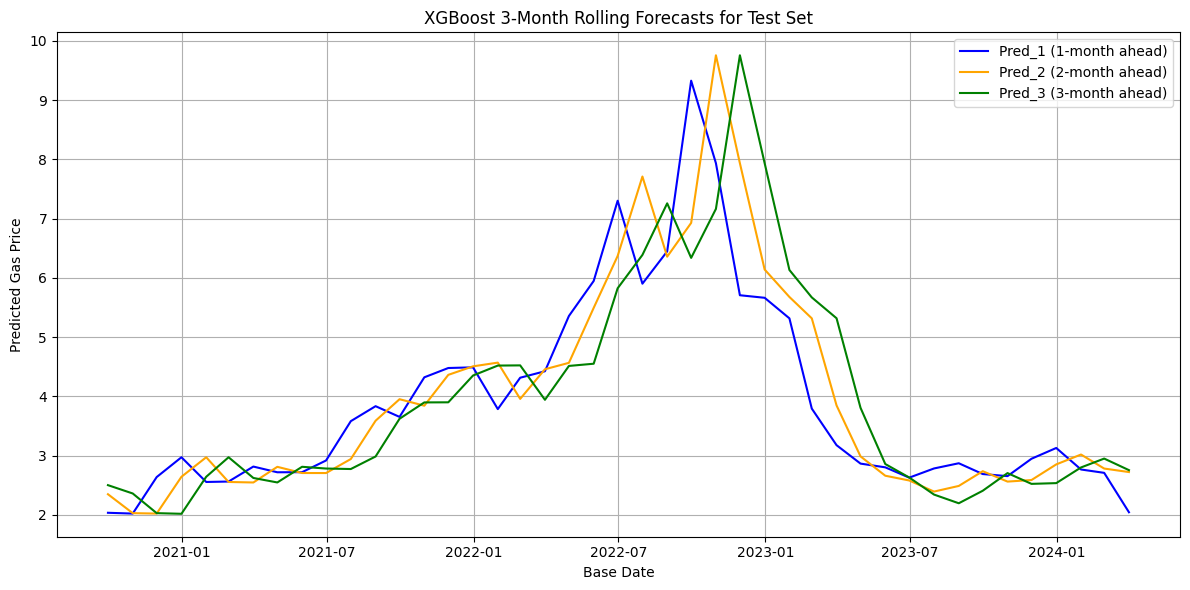

✅ Forecasts saved to: /content/drive/MyDrive/Colab_Notebooks/xgb_3month_forecasts.csv


In [20]:
# === Load training data
df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/cleaned_data.csv", parse_dates=["date"])
df.set_index("date", inplace=True)

# === Load test data
df_test = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/cleaned_data_test.csv", parse_dates=["date"])
df_test.set_index("date", inplace=True)

# === Define target column
target_col = 'Natural_Gas_US_Henry_Hub_Gas'

# === STEP 1: Extract 2019 data from training set to use for lag history
df_2019 = df[df.index.year == 2019]

# === STEP 2: Combine 2019 history with the test set
combined = pd.concat([df_2019, df_test])

# === STEP 3: Create lag features (lag_1 to lag_12) on the combined data
for lag in range(1, 13):
    combined[f'lag_{lag}'] = combined[target_col].shift(lag)

# === STEP 4: Extract only the test portion (now with valid lag features)
df_test_lagged = combined.loc[df_test.index]

# === STEP 5: Prepare for 3-month rolling forecasts
base_dates = df_test_lagged.index
future_preds = []
latest_known = df_test_lagged.copy()
lag_cols = [f'lag_{i}' for i in range(1, 13)]

# === STEP 6: Loop over each test date and forecast 3 future values
for base_date in base_dates:
    try:
        # Skip rows with missing lag values
        if latest_known.loc[base_date, lag_cols].isnull().any():
            continue

        # Extract last 12 lag values
        rolling_vals = latest_known.loc[base_date, lag_cols].tolist()
        preds = []

        # Predict next 3 months recursively
        for _ in range(3):
            X_input = np.array(rolling_vals[-12:]).reshape(1, -1)
            pred = model.predict(X_input)[0]
            preds.append(pred)
            rolling_vals.append(pred)

        # Store predictions for this base date
        future_preds.append((base_date.strftime("%Y-%m-%d"), *preds))

        # Simulate time advancing by adding the first prediction to latest_known
        new_row = pd.DataFrame({target_col: preds[0]}, index=[base_date])
        latest_known = pd.concat([latest_known, new_row])

    except Exception as e:
        print(f"⚠️ Skipped {base_date.date()}: {e}")
        continue

# === STEP 7: Create forecast DataFrame
forecast_df = pd.DataFrame(future_preds, columns=["date", "pred_1", "pred_2", "pred_3"])
forecast_df['date'] = pd.to_datetime(forecast_df['date'])
forecast_df.set_index('date', inplace=True)

# === STEP 8: Show a preview of the forecast
print("\n📊 3-Month Forecasts for All Valid Base Dates:")
print(forecast_df.head())

# === STEP 9: Plot the forecasts
plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df['pred_1'], label='Pred_1 (1-month ahead)', color='blue')
plt.plot(forecast_df.index, forecast_df['pred_2'], label='Pred_2 (2-month ahead)', color='orange')
plt.plot(forecast_df.index, forecast_df['pred_3'], label='Pred_3 (3-month ahead)', color='green')
plt.title('XGBoost 3-Month Rolling Forecasts for Test Set')
plt.xlabel("Base Date")
plt.ylabel("Predicted Gas Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === STEP 10: Save forecast results to CSV
output_path = "/content/drive/MyDrive/Colab_Notebooks/xgb_3month_forecasts.csv"
forecast_df.to_csv(output_path)
print(f"✅ Forecasts saved to: {output_path}")

# Listing Inflection Points

In [21]:
# === Function to detect inflection points based on value differences
def detect_inflections(series, threshold=1.5):
    """
    Detect inflection points (local maxima or minima) where the difference from
    neighbors is large enough (>= threshold).

    Parameters:
    - series: 1D numeric array
    - threshold: minimum value difference from neighbors to be considered significant

    Returns:
    - List of index positions of inflection points
    """
    inflection_indices = []
    for i in range(1, len(series) - 1):
        prev, curr, next_ = series[i-1], series[i], series[i+1]

        # Detect strong peak
        if curr > prev and curr > next_ and (curr - min(prev, next_)) >= threshold:
            inflection_indices.append(i)

        # Detect strong trough
        elif curr < prev and curr < next_ and (max(prev, next_) - curr) >= threshold:
            inflection_indices.append(i)

    return inflection_indices

# === Apply function to each forecast horizon with specified threshold
threshold_value = 1.5  # Minimum change required to be counted as a strong inflection

inflection_1 = detect_inflections(forecast_df['pred_1'].values, threshold=threshold_value)
inflection_2 = detect_inflections(forecast_df['pred_2'].values, threshold=threshold_value)
inflection_3 = detect_inflections(forecast_df['pred_3'].values, threshold=threshold_value)

# === Convert index positions to actual dates from forecast_df index
dates_1 = forecast_df.index[inflection_1]
dates_2 = forecast_df.index[inflection_2]
dates_3 = forecast_df.index[inflection_3]

# === Print the final list of inflection point dates for each forecast horizon
print("Inflection Points (Pred_1 / 1-month ahead):")
for date in dates_1:
    print("-", date.date())

print("Inflection Points (Pred_2 / 2-month ahead):")
for date in dates_2:
    print("-", date.date())

print("Inflection Points (Pred_3 / 3-month ahead):")
for date in dates_3:
    print("-", date.date())

Inflection Points (Pred_1 / 1-month ahead):
- 2022-09-30
Inflection Points (Pred_2 / 2-month ahead):
- 2022-10-31
Inflection Points (Pred_3 / 3-month ahead):
- 2022-11-30


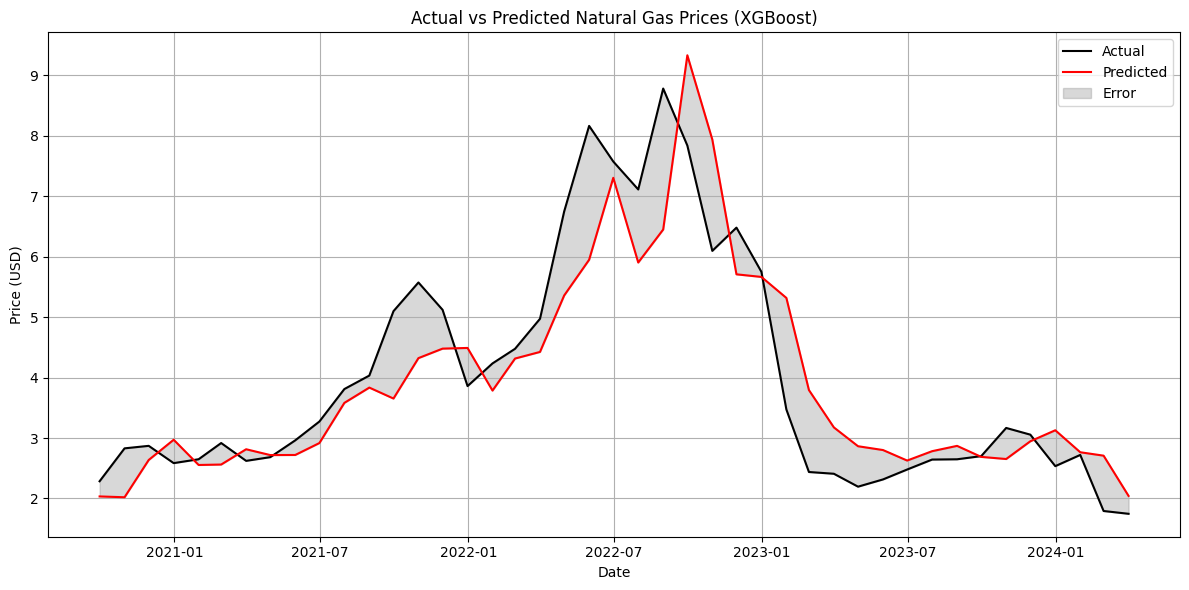

✅ RMSE: 0.8028
✅ MAPE: 16.38%


In [8]:
# === Load actual and forecast data
actual_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/actual_data.csv')
forecast_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/forecasts_submission.csv')

# === Ensure date columns are datetime
actual_df['date'] = pd.to_datetime(actual_df['date'])
forecast_df['date'] = pd.to_datetime(forecast_df['date'])

# === Merge on 'date'
merged_df = pd.merge(actual_df, forecast_df, on='date', how='inner')

# === Convert columns to numeric
merged_df['Natural_Gas_US_Henry_Hub_Gas'] = pd.to_numeric(merged_df['Natural_Gas_US_Henry_Hub_Gas'], errors='coerce')
merged_df['pred_1'] = pd.to_numeric(merged_df['pred_1'], errors='coerce')

# === Drop any missing values
merged_df.dropna(subset=['Natural_Gas_US_Henry_Hub_Gas', 'pred_1'], inplace=True)

# === Compute RMSE and MAPE
y_true = merged_df['Natural_Gas_US_Henry_Hub_Gas']
y_pred = merged_df['pred_1']

rmse = mean_squared_error(y_true, y_pred)

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)

# === Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(merged_df['date'], y_true, label='Actual', color='black')
plt.plot(merged_df['date'], y_pred, label='Predicted', color='red')
plt.fill_between(merged_df['date'], y_true, y_pred, color='gray', alpha=0.3, label='Error')
plt.title("Actual vs Predicted Natural Gas Prices (XGBoost)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Print accuracy results
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAPE: {mape:.2f}%")